In [10]:
# Defining emmbedding function
def get_embedding(bedrock, text):
    modelId = 'amazon.titan-embed-text-v1'
    accept = 'application/json'
    contentType = 'application/json'
    input = {
            'inputText': text
        }
    body=json.dumps(input)
    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept,contentType=contentType)
    response_body = json.loads(response.get('body').read())
    embedding = response_body['embedding']
    return embedding

# Euclidean distance func
def calculate_distance(v1, v2):
    distance = math.dist(v1, v2)
    return distance

In [12]:
# Search and Recommendation
# Let’s assume that you have a collection of documents (the data set). Each document is represented by its embedding. 
# You have been given a query string. The ask is to identify the document that is most relevant to the query string.
# You can achieve this with the following steps:
#     1.Represent the query string with its embedding.
#     2.Calculate the Euclidean distance between the query string and all documents in the data set.
#     3.Sort the distances in ascending order.
#     4.The document with the smallest distance is most relevant to the query string.

import boto3
import json
import math

def search(dataset, v):
    for item in dataset:
        item['distance'] = calculate_distance(item['embedding'], v)
    dataset.sort(key=lambda x: x['distance'])
    return dataset[0]['text']
    
# main function
bedrock = boto3.client(
    service_name='bedrock-runtime'
)
# the data set
t1 = """
The theory of general relativity says that the observed gravitational effect between masses results from their warping of spacetime. 
"""
t2 = """
Quantum mechanics allows the calculation of properties and behaviour of physical systems. It is typically applied to microscopic systems: molecules, atoms and sub-atomic particles. 
"""
t3 = """
Wavelet theory is essentially the continuous-time theory that corresponds to dyadic subband transforms — i.e., those where the L (LL) subband is recursively split over and over.
"""
t4 = """
Every particle attracts every other particle in the universe with a force that is proportional to the product of their masses and inversely proportional to the square of the distance between their centers.
"""
t5 = """
The electromagnetic spectrum is the range of frequencies (the spectrum) of electromagnetic radiation and their respective wavelengths and photon energies. 
"""
dataset = [
    {'text': t1, 'embedding': get_embedding(bedrock, t1)}, 
    {'text': t2, 'embedding': get_embedding(bedrock, t2)}, 
    {'text': t3, 'embedding': get_embedding(bedrock, t3)}, 
    {'text': t4, 'embedding': get_embedding(bedrock, t4)}, 
    {'text': t5, 'embedding': get_embedding(bedrock, t5)}
]
# perform a search for Albert Einstein
query = 'Isaac Newton'
v = get_embedding(bedrock, query)              
result = search(dataset, v)
print(result)


Every particle attracts every other particle in the universe with a force that is proportional to the product of their masses and inversely proportional to the square of the distance between their centers.



In [13]:
# Classification

# Let’s assume that you have a collection of documents (the data set) and you would like to classify them into N classes (labels).
# Each class has a label name along with a short description. 
# You can achieve this with the following steps:

#     1.Represent each class with the embedding of the label name and description.
#     2.For a given document, calculate the Euclidean distance between the document and all classes.
#     3.Classify the document into the class with the shortest distance.

def classify(classes, v):
    for item in classes:
        item['distance'] = calculate_distance(item['embedding'], v)
    classes.sort(key=lambda x: x['distance'])
    return classes[0]['name']
    
# main function
bedrock = boto3.client(
    service_name='bedrock-runtime'
)
# the data set
classes = [    
    {'name': 'athletics', 'description': 'all students with a talent in sports'}, 
    {'name': 'musician', 'description': 'all students with a talent in music'}, 
    {'name': 'magician', 'description': 'all students with a talent in witch craft'}
]
for item in classes:
    item['embedding'] = get_embedding(bedrock, item['description'])
# perform a classification
query = 'Ellison sends a spell to prevent Professor Wang from entering the classroom'
v = get_embedding(bedrock, query)
result = classify(classes, v)
print(result)



magician


In [14]:
# Clustering (grouping)

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def get_embedding(bedrock, text):
    modelId = 'amazon.titan-embed-text-v1'
    accept = 'application/json'
    contentType = 'application/json'
    input = {
            'inputText': text
        }
    body=json.dumps(input)
    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept,contentType=contentType)
    response_body = json.loads(response.get('body').read())
    embedding = response_body['embedding']
    return embedding

# main function
bedrock = boto3.client(
    service_name='bedrock-runtime'
)
names = ['Albert Einstein', 'Bob Dylan', 'Elvis Presley', 
         'Isaac Newton', 'Michael Jackson', 'Niels Bohr', 
         'Taylor Swift', 'Hank Williams', 'Werner Heisenberg', 
         'Stevie Wonder', 'Marie Curie', 'Ernest Rutherford']
embeddings = []
for name in names:
    embeddings.append(get_embedding(bedrock, name))
# clustering
df = pd.DataFrame(data={'names': names, 'embeddings': embeddings})
matrix = np.vstack(df.embeddings.values)
n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['cluster'] = kmeans.labels_
# result
print(df[['cluster', 'names']])


    cluster              names
0         1    Albert Einstein
1         0          Bob Dylan
2         0      Elvis Presley
3         1       Isaac Newton
4         0    Michael Jackson
5         1         Niels Bohr
6         0       Taylor Swift
7         0      Hank Williams
8         1  Werner Heisenberg
9         0      Stevie Wonder
10        1        Marie Curie
11        1  Ernest Rutherford


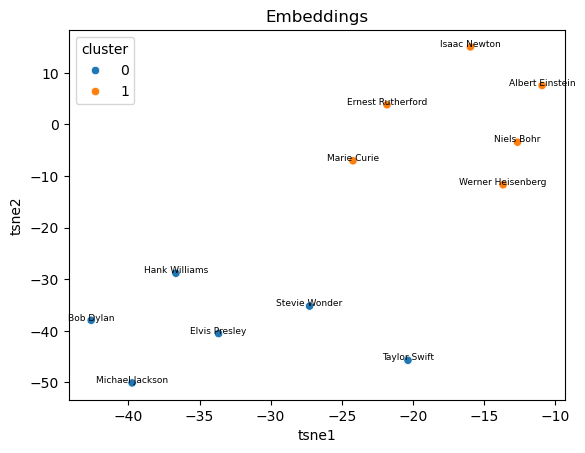

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce number of dimensions from 1536 to 2
tsne = TSNE(random_state=0, n_iter=1000, perplexity=6)
tsne_results = tsne.fit_transform(np.array(df['embeddings'].to_list(), dtype=np.float32))
# Add the results to dataframe as a new column
df['tsne1'] = tsne_results[:, 0]
df['tsne2'] = tsne_results[:, 1]

# Plot the data and annotate the result
fig, ax = plt.subplots()
ax.set_title('Embeddings')
sns.scatterplot(data=df, x='tsne1', y='tsne2', hue='cluster', ax=ax)
for idx, row in df.iterrows():
    ax.text(row['tsne1'], row['tsne2'], row['names'], fontsize=6.5, horizontalalignment='center')

plt.show()


In [16]:
# Anomaly Detection

def find_outliers_by_count(dataset, count):
    # find the center of mass
    embeddings = []
    for item in dataset:
        embeddings.append(item['embedding'])
    center = np.mean(embeddings, axis=0)
    # calculate distance from center
    for item in dataset:
        item['distance'] = calculate_distance(item['embedding'], center)
    # sort the distances in reverse order
    dataset.sort(key=lambda x: x['distance'], reverse=True)
    # return N outliers
    return dataset[0:count]

# main function
bedrock = boto3.client(
    service_name='bedrock-runtime'
)
names = ['Albert Einstein', 'Isaac Newton', 'Stephen Hawking', 
         'Galileo Galilei', 'Niels Bohr', 'Werner Heisenberg', 
         'Marie Curie', 'Ernest Rutherford', 'Michael Faraday', 
         'Richard Feynman', 'Lady Gaga', 'Erwin Schrödinger', 
         'Max Planck', 'Enrico Fermi', 'Taylor Swift', 'Lord Kelvin']
dataset = []
for name in names:
    embedding = get_embedding(bedrock, name)
    dataset.append({'name': name, 'embedding': embedding})
outliers = find_outliers_by_count(dataset, 2)
for item in outliers:
    print(item['name'])


Taylor Swift
Lady Gaga


In [20]:
# identify outliers by the percentage of max distance

def find_outliers_by_distance(dataset, percent):
    # find the center of mass
    embeddings = []
    for item in dataset:
        embeddings.append(item['embedding'])
    center = np.mean(embeddings, axis=0)
    # calculate distance from center
    for item in dataset:
        item['distance'] = calculate_distance(item['embedding'], center)
    # sort the distances in reverse order
    dataset.sort(key=lambda x: x['distance'], reverse=True)
    # return outliers beyond x% of max distance
    max_distance = dataset[0]['distance']
    min_distance = percent * max_distance / 100
    outliers = []
    for item in dataset:
        if item['distance'] >= min_distance:
            outliers.append(item)
    return outliers

# change the main function to use find_outliers_by_distance()
entries = find_outliers_by_distance(dataset, 80)
for item in entries:
    print(item['name'])

Taylor Swift
Lady Gaga
